# **Modelling**

## **Step1.** Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#flights table
data = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_table(50,000_points).csv',delimiter=';')
data = data.iloc[: , 1:]

#create two samples of 10,000 points each
sample1 = data.sample(n=10000, random_state=0)
sample2 = data.sample(n=10000, random_state=1)

#Adding date time features and state
sample1['month'] = pd.DatetimeIndex(sample1['fl_date']).month
sample2['month'] = pd.DatetimeIndex(sample2['fl_date']).month
sample1['year'] = pd.DatetimeIndex(sample1['fl_date']).year
sample2['year'] = pd.DatetimeIndex(sample2['fl_date']).year
sample1['origin_city_state'] = sample1['origin_city_name'].transform(lambda x: str(x).split(',')[1])
sample2['origin_city_state'] = sample2['origin_city_name'].transform(lambda x: str(x).split(',')[1])
sample1['depart_hour'] = sample1['dep_time'].round(-2)
sample2['depart_hour'] = sample2['dep_time'].round(-2)

In [3]:
display(data.head(3))
display(data.shape)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-12-30,WN,WN,WN,775,WN,N255WN,775,13495,MSY,...,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-08,AS,AS,AS,352,AS,N464AS,352,14747,SEA,...,672.0,0.0,0.0,25.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-11-21,DL,DL,DL,1312,DL,N912DL,1312,10994,CHS,...,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(50000, 42)

## **Step2.** Create BaseModel using Linear Regression

In [4]:
#create test model df
test_model_1 = sample1[['month','origin_city_state','depart_hour','arr_delay']]

# Droping nan value rows
test_model_1.dropna(inplace=True)

# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
test_model_1['origin_city_state'] = test_model_1['origin_city_state'].astype('category')
test_model_1['origin_city_state'] = test_model_1['origin_city_state'].cat.codes

#Assign train and target variables
X = test_model_1[['month','origin_city_state','depart_hour']]
y = test_model_1['arr_delay']

<ipython-input-4-ac5d82c39b9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_1.dropna(inplace=True)
<ipython-input-4-ac5d82c39b9a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_1['origin_city_state'] = test_model_1['origin_city_state'].astype('category')
<ipython-input-4-ac5d82c39b9a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [5]:
# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#initialize and fit training dataset
Linear_Regressor = LinearRegression()
Linear_Regressor.fit(X_train, y_train)

#make prediction 
y_pred = Linear_Regressor.predict(X_test)

#prints the coefficients used for each attribute
print('variables', list(X.columns))
print('coefficients:', Linear_Regressor.coef_)
print()

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(Linear_Regressor.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

variables ['month', 'origin_city_state', 'depart_hour']
coefficients: [-0.07959701  0.04777177  0.01045926]

R2 Score for train data: 0.012
R2 Score2 for test data: 0.015
MAE Score for test data:  23.62


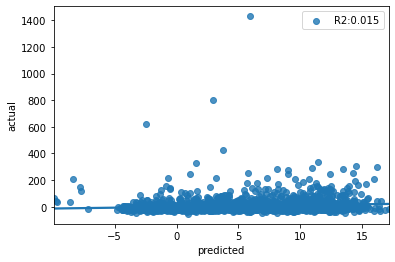

In [6]:
df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)

## **Step3.** Optimize model with better features and cleaner dataset

In [107]:
# load dataset (50,000 datapoints)
data = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_table(50,000_points).csv',delimiter=';')
data = data.iloc[: , 1:]

In [108]:
# drop all cancelled and diverted flights
filter1 = (data['cancelled']!=1) & (data['diverted']!=1)
data = data[filter1]

# drop outliers
data = data[(data['arr_delay']<50) & (data['arr_delay']>-50)]
data = data[(data['dep_delay']<50) & (data['dep_delay']>-50)]

#Adding date time features and state
data['month'] = pd.DatetimeIndex(data['fl_date']).month
data['year'] = pd.DatetimeIndex(data['fl_date']).year
data['day'] = pd.DatetimeIndex(data['fl_date']).day
data['origin_city_state'] = data['origin_city_name'].transform(lambda x: str(x).split(',')[1])
data['origin_city'] = data['origin_city_name'].transform(lambda x: str(x).split(',')[0])
data['dest_city_state'] = data['dest_city_name'].transform(lambda x: str(x).split(',')[1])
data['dest_city'] = data['dest_city_name'].transform(lambda x: str(x).split(',')[0])
data['depart_hour'] = data['dep_time'].round(-2)

# Add key features
data['Route'] = data['origin_city'] + ' to ' + data['dest_city']

data['dep_delay_route'] = data[['dep_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['arr_delay_route'] = data[['arr_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['taxi_out_route'] = data[['taxi_out','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['taxi_in_route'] = data[['taxi_in','Route']].groupby(by='Route').transform(lambda x: x.mean())

data['dep_delay_city'] = data[['dep_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['arr_delay_city'] = data[['arr_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['taxi_out_city'] = data[['taxi_out','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['taxi_in_city'] = data[['taxi_in','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())

data['dep_delay_month'] = data[['dep_delay','month']].groupby(by='month').transform(lambda x: x.mean())
data['arr_delay_month'] = data[['arr_delay','month']].groupby(by='month').transform(lambda x: x.mean())
data['taxi_out_month'] = data[['taxi_out','month']].groupby(by='month').transform(lambda x: x.mean())
data['taxi_in_month'] = data[['taxi_in','month']].groupby(by='month').transform(lambda x: x.mean())


#drop columns
data = data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month','arr_delay']]

In [109]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

display(missing_data.head(20))
display(data.shape)

,Total,Percent
air_time,24,0.000538
arr_delay,0,0.000000
taxi_in_month,0,0.000000
day,0,0.000000
year,0,0.000000
origin_city,0,0.000000
origin_city_state,0,0.000000
dest_city,0,0.000000
dest_city_state,0,0.000000
Route,0,0.000000


(44575, 24)

In [110]:
#drop null values
data = data.dropna()
display(data.shape)

(44551, 24)

In [111]:
df.drop_duplicates()
display(data.shape)

(44551, 24)

In [112]:
display(data.head())
display(data.shape)

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,...,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,dep_delay_month,arr_delay_month,taxi_out_month,taxi_in_month,arr_delay
0,12,30,2019,New Orleans,LA,Fort Lauderdale,FL,New Orleans to Fort Lauderdale,674.0,84.0,...,8.444444,1.710611,-4.176849,11.800643,8.057878,0.892546,-5.488575,17.429543,7.718988,-3.0
1,4,8,2018,Seattle,WA,Oakland,CA,Seattle to Oakland,672.0,98.0,...,6.208333,1.014692,-4.634527,19.509642,6.965106,-0.054939,-5.735341,16.802538,7.431139,25.0
2,11,21,2018,Charleston,SC,Atlanta,GA,Charleston to Atlanta,259.0,46.0,...,10.238095,-1.163522,-7.421384,14.861635,8.779874,0.093850,-5.732620,16.940107,7.404545,-13.0
3,12,19,2019,Fort Lauderdale,FL,Pittsburgh,PA,Fort Lauderdale to Pittsburgh,994.0,128.0,...,5.333333,1.163701,-4.740214,17.135231,7.814947,0.892546,-5.488575,17.429543,7.718988,-16.0
4,9,21,2019,Roanoke,VA,Chicago,IL,Roanoke to Chicago,530.0,82.0,...,10.666667,1.934783,-4.913043,18.152174,8.673913,-0.826569,-6.520833,16.681560,7.540753,-36.0


(44551, 24)

In [113]:
# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
data['origin_city_state'] = data['origin_city_state'].astype('category')
data['origin_city'] = data['origin_city'].astype('category')
data['dest_city_state'] = data['dest_city_state'].astype('category')
data['dest_city'] = data['dest_city'].astype('category')
data['Route'] = data['Route'].astype('category')

data['origin_city_state'] = data['origin_city_state'].cat.codes
data['origin_city'] = data['origin_city'].cat.codes
data['dest_city_state'] = data['dest_city_state'].cat.codes
data['dest_city'] = data['dest_city'].cat.codes
data['Route'] = data['Route'].cat.codes

In [114]:
display(data.head())
display(data.shape)

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,...,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,dep_delay_month,arr_delay_month,taxi_out_month,taxi_in_month,arr_delay
0,12,30,2019,220,17,105,8,2987,674.0,84.0,...,8.444444,1.710611,-4.176849,11.800643,8.057878,0.892546,-5.488575,17.429543,7.718988,-3.0
1,4,8,2018,296,49,233,4,4370,672.0,98.0,...,6.208333,1.014692,-4.634527,19.509642,6.965106,-0.054939,-5.735341,16.802538,7.431139,25.0
2,11,21,2018,52,40,17,9,604,259.0,46.0,...,10.238095,-1.163522,-7.421384,14.861635,8.779874,0.093850,-5.732620,16.940107,7.404545,-13.0
3,12,19,2019,103,8,249,37,1730,994.0,128.0,...,5.333333,1.163701,-4.740214,17.135231,7.814947,0.892546,-5.488575,17.429543,7.718988,-16.0
4,9,21,2019,267,46,61,13,3848,530.0,82.0,...,10.666667,1.934783,-4.913043,18.152174,8.673913,-0.826569,-6.520833,16.681560,7.540753,-36.0


(44551, 24)

In [115]:
#Assign train and target variables
X = data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month']]
y = data['arr_delay']

# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#initialize and fit training dataset
Linear_Regressor = LinearRegression()
Linear_Regressor.fit(X_train, y_train)

#make prediction 
y_pred = Linear_Regressor.predict(X_test)

#prints the coefficients used for each attribute
print('variables', list(X.columns))
print('coefficients:', Linear_Regressor.coef_)
print()

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(Linear_Regressor.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

variables ['month', 'day', 'year', 'origin_city', 'origin_city_state', 'dest_city', 'dest_city_state', 'Route', 'distance', 'air_time', 'depart_hour', 'dep_delay_route', 'arr_delay_route', 'taxi_out_route', 'taxi_in_route', 'dep_delay_city', 'arr_delay_city', 'taxi_out_city', 'taxi_in_city', 'dep_delay_month', 'arr_delay_month', 'taxi_out_month', 'taxi_in_month']
coefficients: [-3.20954591e-02  3.50808909e-04 -3.32329141e-01 -9.54766740e-03
 -1.31835684e-02 -4.34790556e-03  4.40292522e-03  8.79979738e-04
 -3.51500541e-02  2.99743638e-01  3.30375563e-03  1.12509210e-01
  8.53893543e-01  1.07917652e-01 -6.29522355e-02 -3.28976879e-01
  3.36282118e-01 -2.93094915e-01 -3.12688828e-01 -6.32303586e-01
  1.17583505e+00 -2.40475550e-01  1.98725756e+00]

R2 Score for train data: 0.195
R2 Score2 for test data: 0.196
MAE Score for test data:  10.66


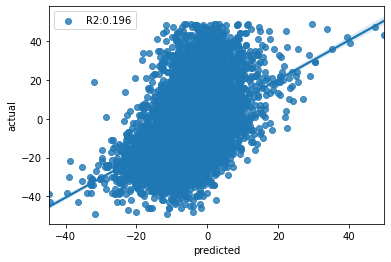

In [116]:
df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)

In [21]:
data.head()

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,depart_hour,dep_delay_route,arr_delay_route,taxi_out_route,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,arr_delay
0,12,30,2019,New Orleans,LA,Fort Lauderdale,FL,New Orleans to Fort Lauderdale,674.0,84.0,600.0,1.888889,-1.555556,11.222222,8.444444,1.710611,-4.176849,11.800643,8.057878,-3.0
1,4,8,2018,Seattle,WA,Oakland,CA,Seattle to Oakland,672.0,98.0,600.0,4.541667,-0.166667,18.166667,6.208333,1.014692,-4.634527,19.509642,6.965106,25.0
2,11,21,2018,Charleston,SC,Atlanta,GA,Charleston to Atlanta,259.0,46.0,800.0,-3.142857,-5.904762,15.714286,10.238095,-1.163522,-7.421384,14.861635,8.779874,-13.0
3,12,19,2019,Fort Lauderdale,FL,Pittsburgh,PA,Fort Lauderdale to Pittsburgh,994.0,128.0,2200.0,-4.333333,-5.833333,22.666667,5.333333,1.163701,-4.740214,17.135231,7.814947,-16.0
4,9,21,2019,Roanoke,VA,Chicago,IL,Roanoke to Chicago,530.0,82.0,1100.0,2.500000,0.000000,22.000000,10.666667,1.934783,-4.913043,18.152174,8.673913,-36.0
